# Identifying tree species from photos of their leaves

Leafsnap (http://leafsnap.com) is an electronic field guide for identifying tree
species from photos of their leaves. It was jointly created by computer
scientists from Columbia University and the University of Maryland, and
botanists from the Smithsonian Institution in Washington, DC.
The dataset covers all 185 tree species from the Northeastern United States.

Ref: 

Neeraj Kumar, Peter N. Belhumeur, Arijit Biswas, David W. Jacobs, W. John Kress, Ida Lopez, JoÃ£o V. B. Soares,
"Leafsnap: A Computer Vision System for Automatic Plant Species Identification,"
Proceedings of the 12th European Conference on Computer Vision (ECCV),
October 2012.

In [1]:
#donload libraries
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF

%matplotlib inline

### Dataset



The images stored in into two categories:

1. 23147 Lab images, consisting of high-quality images taken of pressed leaves, from the Smithsonian collection. These images appear in controlled backlit and front-lit versions, with several samples per species.

2. 7719 Field images, consisting of "typical" images taken by mobile devices 2.2(iPhones mostly) in outdoor environments. These images contain varying amounts of blur, noise, illumination patterns, shadows, etc.

I merged them into one folder, separated by names.


In [2]:
classes = os.listdir('data')
classes.sort()

In [3]:
print("Number of classes per leaf dataset:",len(classes))

Number of classes per leaf dataset: 185


let's print number of images for the first 10 classes

In [4]:
for cla in classes[0:10]:
  print (cla, ": number of images ", len(os.listdir('data/'+cla)))

abies_concolor : number of images  251
abies_nordmanniana : number of images  159
acer_campestre : number of images  144
acer_ginnala : number of images  151
acer_griseum : number of images  126
acer_negundo : number of images  229
acer_palmatum : number of images  212
acer_pensylvanicum : number of images  155
acer_platanoides : number of images  140
acer_pseudoplatanus : number of images  135


In [5]:
f= open("D:\__AI_Courses_certif\__Udacity\__Projects\pytorch_onnx_openvino-master\labels.txt","w+")
for cla in classes:
 f.write(cla+"\n")
f.close() 

Next, we can display random lab and field images to see how they differ in size and quality

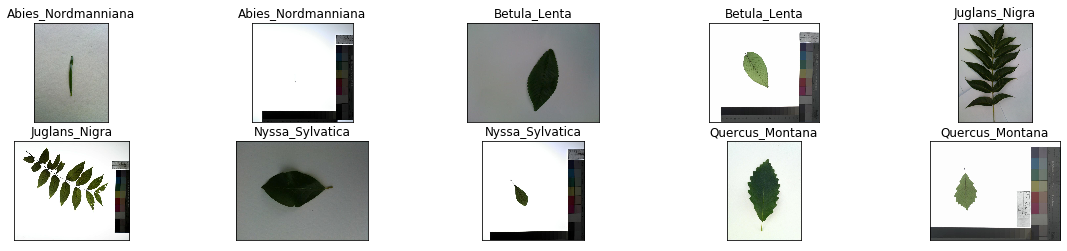

In [6]:
# helper display function
def imshow_raw(img, title = None):
    img = mpimg.imread(img)
    if title:
        plt.title(title)
    plt.imshow(img)
    
#random images from dataset
random_images =['data/abies_nordmanniana/13291651129246.jpg', 
         'data/abies_nordmanniana/ny1057-01-3.jpg', 
         'data/betula_lenta/1248106459_0000.jpg',
         'data/betula_lenta/wb1193-06-4.jpg',
         'data/juglans_nigra/1249316300_0002.jpg',
         'data/juglans_nigra/pi2116-03-3.jpg',
         'data/nyssa_sylvatica/12992004532153.jpg',
         'data/nyssa_sylvatica/ny1128-02-4.jpg',
         'data/quercus_montana/13292231174757.jpg',
         'data/quercus_montana/pi0037-03-4.jpg',
         'data/quercus_montana/pi0037-03-2.jpg']        

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20,4))
plot_size=10
for i in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, i+1, xticks=[], yticks=[])
    imshow_raw(random_images[i], random_images[i].split('/')[-2].title())
   

### Download Data

Download and pre-process data
1. Split into trainig, validation and test 
2. Normalize the images
3. Perform transformation
- resize


- crop

- flip

- rotate


In [7]:
data_dir = 'data'
# arrays to normalization
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])

## we can additional transformation to train data, but it is much slower to train and converge
# train_transforms = transforms.Compose([ transforms.RandomChoice([
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.RandomRotation(180),
#         ]),
#     transforms.RandomResizedCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         normalize_mean,
#         normalize_std)
#     ])

transforms = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
                          
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)])
    
# train_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
# test_dataset = datasets.ImageFolder(data_dir, transform=test_transforms)
dataset = datasets.ImageFolder(data_dir, transform=transforms)
#dataset.classes

In [8]:
# initiate parameters for splitting our data
num_workers = 1
batch_size =16
valid_size = 0.1
test_size = 0.1

num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(0.8 * num_train))
split_1 = int(np.floor(0.1 * num_train))
split_2 = split+split_1

train_idx, valid_idx, test_idx = (indices[:split], indices[split:split_2],
                                  indices[split_2+1:])

# define samplers for obtaining training, validation and test batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler =  SubsetRandomSampler(test_idx)
# load our batches
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=test_sampler,                                       
                                           num_workers=num_workers)
len(train_idx), len(indices),len(valid_idx), len(test_idx)
print("Length of dataset: ",len(indices))
print("Length of training set: ",len(train_idx))
print("Length of validation set: ",len(valid_idx))
print("Length of test set: ",len(test_idx))

Length of dataset:  30866
Length of training set:  24692
Length of validation set:  3086
Length of test set:  3087


In [9]:
def imshow(img, title=None):
    # un-normalize
    for i in range(img.shape[0]):
        img[i] = img[i] * normalize_std[i] + normalize_mean[i]
    
    if title:
        plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor

Display one transformed training batch

Batch shape: (16, 3, 224, 224)


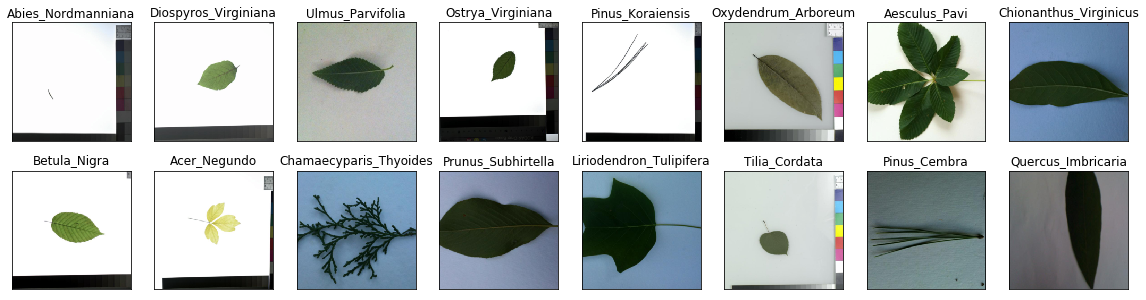

In [10]:
#display training batch
dataiter = iter(train_loader)

images, labels = dataiter.next()
images = images.numpy()
labels = labels.tolist()

print("Batch shape:",images.shape)
fig = plt.figure(figsize=(20,5))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(batch_size/8, batch_size/(batch_size/8), idx+1, xticks=[], yticks=[])    
    imshow(images[idx], classes[labels[idx]].title())
    

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA available.  Training on GPU ...')

CUDA available.  Training on GPU ...


### VGG 16 CNN model

Simple CNN architecture

- 5 conv layers with a kernel size of 3
- pooling layers 2x2 after the second and last layers 
- 3 fully connected layers

Although, it is very slow and doesn't perform well.

In [12]:
# #shorter version of VGG 16 CNN architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)   
#         self.conv2 = nn.Conv2d(6, 12, 3, padding=1)      
#         self.conv3 = nn.Conv2d(12, 24, 3, padding=1)
#         self.conv4 = nn.Conv2d(24, 48, 3, padding=1)      
#         self.conv5 = nn.Conv2d(48, 96, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)       
#         self.fc1 = nn.Linear(13*13*96, 4096)       
#         self.fc2 = nn.Linear(4096 , 4096)
#         self.fc3 = nn.Linear(4096, 185)       
#         self.dropout = nn.Dropout(0.01)

#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pool(F.relu(self.conv5(x)))
#         # flatten image input and add hidden layers with dropout and
#         # activation function ReLu
#         #print("conv output shape", x.shape)
#         x = self.dropout(x.view(-1,  13*13*96))     
#         x = self.dropout(F.relu(self.fc1(x)))       
#         x = self.dropout(F.relu(self.fc2(x)))        
#         x = self.fc3(x)
        
#         return x

# model = Net()
# # move tensors to GPU if CUDA is available
# if train_on_gpu:
#     model.cuda()
# print(model)
# #loss function for custom cnn
# criterion = nn.CrossEntropyLoss()
# #optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.03)

In [13]:
# #loss function for custom cnn
# criterion = nn.CrossEntropyLoss()
# #optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.03)

### VGG-19 pre-trained **model**

![alt text](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)


Load and freeze parameters in VGG19 pre-trained model.

In [14]:
model = models.vgg19_bn(pretrained=True)

In [15]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 500)),
                          ('relu', nn.ReLU()),
                          ('dr', nn.Dropout(p=0.1)),
                          ('fc2', nn.Linear(500, 185)),
                          ('output', nn.LogSoftmax(dim=1))#LogSoftmax
                          ]))
                          
    
model.classifier = classifier
criterion =  nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.classifier.parameters(), lr=0.03)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Training

It took me around 1.5 hours to train the model(10 epochs) on GPU with a batch size of 16. Also, I haven't tried any other optimizers and learning rate was constant 0.03 through training. So, there is room for improvement. Just to mention, the model trained better without extra transformation(flip, rotation).

In [ ]:
import time
tstart=time.time()

# number of epochs to train the model
n_epochs = 20
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0    
    
    # train the model    
    
    model.train()
    for data, target in train_loader:        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()       
        optimizer.zero_grad()        
        output = model(data)  
        #print(output.shape)     
        loss = criterion(output, target)       
        loss.backward()       
        optimizer.step()       
        train_loss += loss.item()*data.size(0)
    
    # validate the model 
  
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
       
        output = model(data)       
        loss = criterion(output, target)       
        valid_loss += loss.item()*data.size(0)    
   
    train_loss = train_loss/len(train_idx)
    valid_loss = valid_loss/len(valid_idx)        
   
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_leaf_01.pt')
        valid_loss_min = valid_loss
        
tstop=time.time()
print("Inference time : "+str(1000*(tstop-tstart))+" ms")

Epoch: 1 	Training Loss: 1.856543 	Validation Loss: 0.700476
Validation loss decreased (inf --> 0.700476).  Saving model ...
Epoch: 2 	Training Loss: 0.418516 	Validation Loss: 0.899386


### Test the model

Test and visualize our model. Credits to Udacity for multi classes validation and plotting. [GitHub](https://github.com/udacity/deep-learning-v2-pytorch)

Test on test dataset

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(185))
class_total = list(0. for i in range(185))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(15):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
#labels=[classes[l].title() for l in classez]

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 15))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} \n({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Download silver maple (Acer platanoides) [leaf image](http://www.tree-guide.com/silver-maple)

In [ ]:
!wget http://www.tree-guide.com/images/styles/600x450-copy_/public/norway-maple-leaf-underside.jpg
test_image = 'norway-maple-leaf-underside.jpg'
test_image_name = "Acer Platanoides"

In [ ]:
def predict(image_path, model, topk=5):
    # Predict the class (or classes) of an image using a trained deep learning model.
     
    # Implement the code to predict the class from an image file
    image = Image.open(image_path)
    image = process_image(image)
    
    with torch.no_grad():
        model.eval()
        
        image = image.view(1,3,224,224)
        image = image.to(device)
        
        predictions = model.forward(image)
        
        predictions = torch.exp(predictions)
        top_ps, top_class = predictions.topk(topk, dim=1)
    
    return top_ps, top_class

In [ ]:
def process_image(image):
    #  Scales, crops, and normalizes a PIL image for a PyTorch model,
    # returns an Numpy array
    # Process a PIL image for use in a PyTorch model
    image = TF.resize(image, 256)
    upper_pixel = (image.height - 224) // 2
    left_pixel = (image.width - 224) // 2
    image = TF.crop(image, upper_pixel, left_pixel, 224, 224)
    
    image = TF.to_tensor(image)
    image = TF.normalize(image, normalize_mean, normalize_std)   
    
    return image

In [ ]:
probs, classez = predict(test_image, model)
print(probs)
print(classez)

In [ ]:

# Display an image along with the top 5 classes
probs, classez = predict(test_image, model)

probs = probs.data.cpu()
probs = probs.numpy().squeeze()

classez = classez.data.cpu()
classez = classez.numpy().squeeze().tolist()

labels=[classes[l].title() for l in classez]
title = classes[label].title()

fig = plt.figure(figsize=(4, 10))

ax1 = fig.add_subplot(2, 1, 1, xticks=[], yticks=[])

image = Image.open(test_image)
image = process_image(image)
imshow(image, test_image_name )

ax2 = fig.add_subplot(2, 1, 2, xticks=[], yticks=[])
ax2.barh(np.arange(5), probs)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(labels)
ax2.set_ylim(-1, 5)
ax2.invert_yaxis()
ax2.set_xlim(0, 1.1)
ax2.set_title('Top 5 predicted')
plt.show()